Data Preprocessing

In [5]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

# Load the dataset
df = pd.read_csv('ecommerce_purchase_data.csv')
print(df.shape)
df.head()

(3000, 10)


,CustomerID,Age,Gender,AnnualIncome,PurchaseAmount,PurchaseFrequency,LastPurchaseDate,ProductCategory,LoyaltyProgramMember,CustomerRating
0,1.0,56.0,Male,70225.0,125.635565,48.0,01-01-2023,Toys,0.0,1.210366
1,2.0,69.0,Male,57952.0,156.417933,NaN,02-01-2023,Books,0.0,3.201970
2,3.0,46.0,Other,57663.0,244.151650,39.0,03-01-2023,Toys,0.0,2.229175
3,4.0,32.0,Female,81381.0,36.275633,29.0,04-01-2023,Books,1.0,3.134410
4,5.0,60.0,Male,67929.0,307.515054,24.0,NaN,Clothing,1.0,1.537188


In [6]:
# Handle Missing Values

# Drop rows where CustomerID is missing
df.dropna(subset=['CustomerID'], inplace=True)

In [11]:
print(df['LoyaltyProgramMember'].value_counts(dropna=False))
print(df['LoyaltyProgramMember'].isnull().sum())

LoyaltyProgramMember
1.0    1468
0.0    1433
NaN      46
Name: count, dtype: int64
46


In [14]:
# Impute numerical columns with the median
for col in ['Age', 'AnnualIncome', 'PurchaseAmount', 'PurchaseFrequency', 'CustomerRating']:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# Impute categorical columns with the mode
for col in ['Gender', 'ProductCategory', 'LoyaltyProgramMember']:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)

# Convert columns to appropriate integer types after imputation
df['CustomerID'] = df['CustomerID'].astype(int)
df['Age'] = df['Age'].astype(int)
df['PurchaseFrequency'] = df['PurchaseFrequency'].astype(int)
df['LoyaltyProgramMember'] = df['LoyaltyProgramMember'].astype(int)

print("Missing values after cleaning:")
print(df.isnull().sum())

Missing values after cleaning:
CustomerID               0
Age                      0
Gender                   0
AnnualIncome             0
PurchaseAmount           0
PurchaseFrequency        0
LastPurchaseDate        35
ProductCategory          0
LoyaltyProgramMember     0
CustomerRating           0
dtype: int64


In [15]:
# Convert 'LastPurchaseDate' to datetime objects
df['LastPurchaseDate'] = pd.to_datetime(df['LastPurchaseDate'], format='%d-%m-%Y', errors='coerce')

# Impute missing 'LastPurchaseDate' with the mode (most frequent date)
mode_date = df['LastPurchaseDate'].mode()[0]
df['LastPurchaseDate'].fillna(mode_date, inplace=True)

print("Missing values after imputing 'LastPurchaseDate':")
print(df.isnull().sum())

Missing values after imputing 'LastPurchaseDate':
CustomerID              0
Age                     0
Gender                  0
AnnualIncome            0
PurchaseAmount          0
PurchaseFrequency       0
LastPurchaseDate        0
ProductCategory         0
LoyaltyProgramMember    0
CustomerRating          0
dtype: int64


Feature Engineering

In [16]:
# Calculate 'DaysSinceLastPurchase'
latest_date = df['LastPurchaseDate'].max()
df['DaysSinceLastPurchase'] = (latest_date - df['LastPurchaseDate']).dt.days

# Encode Categorical Features

# Use one-hot encoding for 'Gender' and 'ProductCategory'
df_encoded = pd.get_dummies(df, columns=['Gender', 'ProductCategory'], drop_first=True)

# Drop original columns that are no longer needed
df_encoded.drop(['CustomerID', 'LastPurchaseDate'], axis=1, inplace=True)

print("\nDataset after preprocessing and encoding:")
print(df_encoded.head())


Dataset after preprocessing and encoding:
   Age  AnnualIncome  PurchaseAmount  PurchaseFrequency  LoyaltyProgramMember  \
0   56       70225.0      125.635565                 48                     0   
1   69       57952.0      156.417933                 25                     0   
2   46       57663.0      244.151650                 39                     0   
3   32       81381.0       36.275633                 29                     1   
4   60       67929.0      307.515054                 24                     1   

   CustomerRating  DaysSinceLastPurchase  Gender_Male  Gender_Other  \
0        1.210366                   2999         True         False   
1        3.201970                   2998         True         False   
2        2.229175                   2997        False          True   
3        3.134410                   2996        False         False   
4        1.537188                   2999         True         False   

   ProductCategory_Clothing  ProductCategor

Apply Isolation Forest to Detect Outliers

In [17]:
from sklearn.ensemble import IsolationForest

# Define the features for the model
features = df_encoded.columns

# Initialize and fit the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
predictions = iso_forest.fit_predict(df_encoded[features])

# Add outlier predictions to the original dataframe
# -1 indicates an outlier,
# 1 indicates an inlier
df['outlier'] = predictions
df['outlier'] = df['outlier'].map({1: 'Inlier', -1: 'Outlier'})

print("\nNumber of inliers and outliers detected:")
print(df['outlier'].value_counts())


Number of inliers and outliers detected:
outlier
Inlier     2799
Outlier     148
Name: count, dtype: int64


Analyze the Characteristics of Outliers

In [18]:
# Separate inliers and outliers for analysis
outliers_df = df[df['outlier'] == 'Outlier']
inliers_df = df[df['outlier'] == 'Inlier']

# Key features for comparison
analysis_features = ['Age', 'AnnualIncome', 'PurchaseAmount', 'PurchaseFrequency', 'DaysSinceLastPurchase', 'CustomerRating']

print("\nCharacteristics of Outliers:")
print(outliers_df[analysis_features].describe())

print("\nCharacteristics of Inliers:")
print(inliers_df[analysis_features].describe())


Characteristics of Outliers:
              Age   AnnualIncome  PurchaseAmount  PurchaseFrequency  \
count  148.000000     148.000000      148.000000         148.000000   
mean    42.770270   74175.050676      190.760233          26.500000   
std     19.308486   36996.846308      178.567173          18.155976   
min     18.000000   20287.000000        5.310621           1.000000   
25%     23.000000   36168.500000       30.879004           6.750000   
50%     39.000000   82385.500000       95.651594          30.000000   
75%     63.250000  111927.750000      387.936609          44.250000   
max     69.000000  119956.000000      498.580288          49.000000   

       DaysSinceLastPurchase  CustomerRating  
count             148.000000      148.000000  
mean             1541.972973        2.718021  
std              1095.456218        1.376714  
min                 0.000000        1.014587  
25%               316.750000        1.450203  
50%              1726.000000        2.429178  
7

Visualize the Outliers

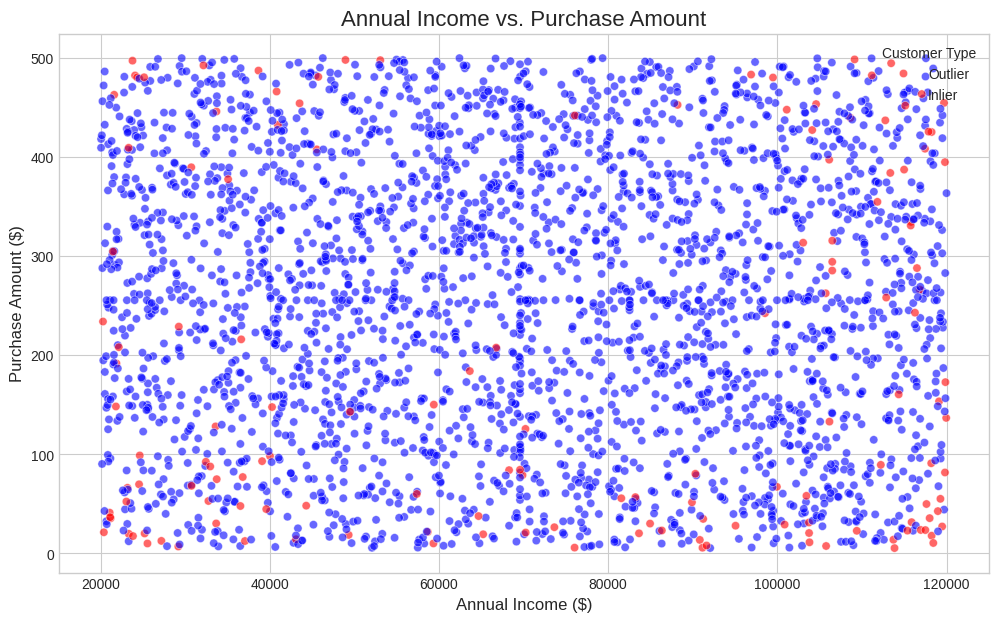

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='AnnualIncome', y='PurchaseAmount', hue='outlier',
                palette={'Inlier':'blue', 'Outlier':'red'}, alpha=0.6)
plt.title('Annual Income vs. Purchase Amount', fontsize=16)
plt.xlabel('Annual Income ($)', fontsize=12)
plt.ylabel('Purchase Amount ($)', fontsize=12)
plt.legend(title='Customer Type')
plt.show()

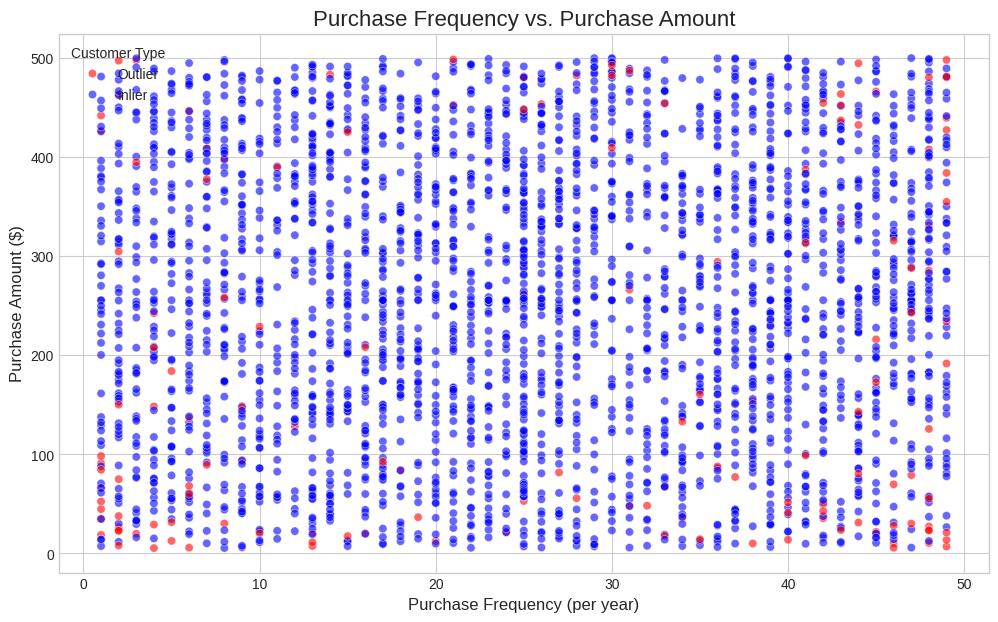

In [27]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='PurchaseFrequency', y='PurchaseAmount', hue='outlier',
                palette={'Inlier':'blue', 'Outlier':'red'}, alpha=0.6)
plt.title('Purchase Frequency vs. Purchase Amount', fontsize=16)
plt.xlabel('Purchase Frequency (per year)', fontsize=12)
plt.ylabel('Purchase Amount ($)', fontsize=12)
plt.legend(title='Customer Type')
plt.show()

Insights

VIP Customers: A group of outliers spends significantly more money. These are likely high-value VIPs.


Churn Risk: Another outlier group consists of customers who haven't purchased in a long time and buy infrequently, indicating they may be at risk of leaving.

Potential Fraud/Data Errors: Some outliers show unusual spending for their income (e.g: low income, high spending), which could be fraud or data entry errors.

